<a href="https://colab.research.google.com/github/bmontoyag/UTEC_MISTI_2026/blob/main/student_Bike_Sharing_Demand_gradient_descent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**If you haven't already, please hit :**

`File` -> `Save a Copy in Drive`

**to copy this notebook to your Google drive, and work on a copy. If you don't do this, your changes won't be saved!**



---



Si aún no lo ha hecho, presione:
`Archivo` -> `Guardar una copia a drive`

**para copiar este cuaderno en su unidad de Google y trabajar en una copia. ¡Si no hace esto, sus cambios no se guardarán!**

# Gradient Descent Optimization

In this colab, we'll combine historical usage patterns with weather data in order to forecast bike rental demand in the Capital Bikeshare program in Washington, D.C.
To read about the dataset, go here: https://www.kaggle.com/competitions/bike-sharing-demand

### Load the Bike Sharing Demand dataset

In [1]:
# IMPORT PACKAGES

from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

# Load dataset
data = fetch_openml(name="Bike_Sharing_Demand", version=2, as_frame=True)
df = data.frame

# view the first couple rows
df.head()


,season,year,month,hour,holiday,weekday,workingday,weather,temp,feel_temp,humidity,windspeed,count
0,spring,0,1,0,False,6,False,clear,9.84,14.395,0.81,0.0,16
1,spring,0,1,1,False,6,False,clear,9.02,13.635,0.80,0.0,40
2,spring,0,1,2,False,6,False,clear,9.02,13.635,0.80,0.0,32
3,spring,0,1,3,False,6,False,clear,9.84,14.395,0.75,0.0,13
4,spring,0,1,4,False,6,False,clear,9.84,14.395,0.75,0.0,1


### Data Pre-Processing

Here we utilize a train-test split and use one-hot encoding for our nominal  features, as we saw yesterday.

In [2]:
# separate the labels from the features
X = df.drop('count', axis=1)
y = df['count'].values.reshape(-1,1)

# One-hot encode categorical features
X = pd.get_dummies(X)

# make training and testing splits
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test  = scaler.transform(X_test)

# add bias term
X_train = np.c_[X_train, np.ones(len(X_train))]
X_test  = np.c_[X_test,  np.ones(len(X_test))]

### Define the prediction function

We'll use a simple linear prediction model in the form $\hat{y} = Xw$

In [3]:
# EXERCISE 1A: define the prediction function
def predict(X, w):
    return X @ w

### Define the loss function
For this exercise we'll use $\mathrm{MSE} = \frac{1}{n}\sum_{i=1}^{n} (y_i - \hat{y}_i)^2$

In [4]:
# EXERCISE 1B: define the loss function
def mse(y_pred, y_true):
    return np.mean((y_true - y_pred)**2)

### Train the model
The derivative of the loss is
>$\nabla_w \mathrm{MSE} = \frac{2}{n} X^T (Xw - y)$

and the update rule for gradient descent is
>$w \leftarrow w - \eta \nabla_w \mathrm{MSE}$

Training time for gd: 0.10s
Training time for sgd: 0.03s
Training time for minibatch: 0.07s
Training time for momentum: 0.10s


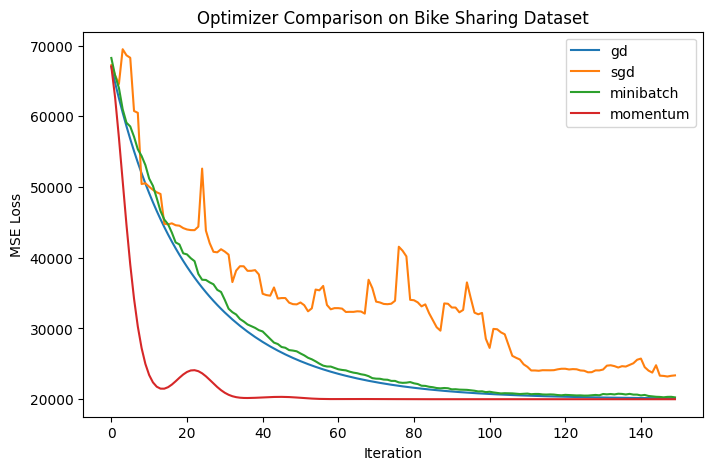

In [5]:
# EXERCISE 1C: find the loss gradient and update the weights
def train(X, y, optimizer="gd", lr=0.01, epochs=150, batch_size=16):
    start_time = time.perf_counter()

    w = np.zeros((X.shape[1], 1))

    history = []
    velocity = np.zeros_like(w)
    m = np.zeros_like(w)
    v = np.zeros_like(w)
    beta1, beta2 = 0.9, 0.999
    eps = 1e-8

    for t in range(1, epochs+1):

        if optimizer == "gd" or optimizer == "momentum":
            # use all the data points
            X_batch, y_batch = X, y

        elif optimizer == "sgd":
            # use a single data point
            i = np.random.randint(len(X))
            X_batch, y_batch = X[i:i+1], y[i:i+1]

        elif optimizer == "minibatch":
            # use 16 data points
            idx = np.random.choice(len(X), batch_size, replace=False)
            X_batch, y_batch = X[idx], y[idx]

        preds = predict(X_batch, w)
        # calculate the loss gradient to update the weights
        grad = (2 / X_batch.shape[0]) * X_batch.T @ (preds - y_batch)

        if optimizer == "momentum":
            # update the velocity term
            velocity = 0.9 * velocity + lr * grad
            w -= velocity
        else:
            # update the weights
            w -= lr * grad

        # Evaluate full training loss
        train_preds = predict(X, w)
        history.append(mse(train_preds, y))

    elapsed = time.perf_counter() - start_time
    print(f"Training time for {optimizer}: {elapsed:0.2f}s")

    return history

# try training with different variations of gradient descent
optimizers = ["gd", "sgd", "minibatch", "momentum"]
results = {}

for opt in optimizers:
    history = train(X_train, y_train, optimizer=opt, lr=0.01, epochs=150)
    results[opt] = history

# Plot Results
plt.figure(figsize=(8,5))
for opt in optimizers:
    plt.plot(results[opt], label=opt)

plt.xlabel("Iteration")
plt.ylabel("MSE Loss")
plt.title("Optimizer Comparison on Bike Sharing Dataset")
plt.legend()
plt.show()